*************
Melhorias a serem feitas no processo da empresa:
- Melhoria no cadastro das vagas, ex: se a vaga pede disponibilidade para viajem;
*************

# Imports

In [24]:
import zipfile
import json
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Métodos

In [25]:
def ler_json(caminho_zip):
  with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    nome_arquivo_json = zip_ref.namelist()[0]  # assumindo que só há um arquivo no zip
    with zip_ref.open(nome_arquivo_json) as file:
        dados = json.load(file)

  # Achatar os dados
  linhas = []
  for chave, conteudo in dados.items():
      linha = {"ID": chave}
      # Flatten (achatar) cada subnível com prefixo
      for secao, valores in conteudo.items():
          if isinstance(valores, dict):
              for subchave, subvalor in valores.items():
                  linha[f"{secao}.{subchave}"] = subvalor
          else:
              linha[secao] = valores
      linhas.append(linha)

  # Criar o DataFrame
  df = pd.DataFrame(linhas)
  return df

In [26]:
def ler_json_candidaturas(caminho_zip):
  with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    nome_arquivo_json = zip_ref.namelist()[0]  # assumindo que só há um arquivo no zip
    with zip_ref.open(nome_arquivo_json) as file:
        dados_candidatura = json.load(file)

  linhas_candidatura = []

  for codigo_vaga, conteudo in dados_candidatura.items():
    prospects = conteudo.get("prospects")

    # Verifica se há prospects e se é uma lista com itens
    if isinstance(prospects, list) and prospects:
        for prospect in prospects:
            linha_candidatura = {
                'codigo_vaga': codigo_vaga,
                'titulo_vaga': conteudo.get('titulo', ''),
                'nome': prospect.get('nome', ''),
                'codigo_candidato': prospect.get('codigo', ''),
                'situacao_candidato': prospect.get('situacao_candidado', ''),
                'data_candidatura': prospect.get('data_candidatura', ''),
                'ultima_atualizacao': prospect.get('ultima_atualizacao', ''),
                'comentario': prospect.get('comentario', ''),
                'recrutador': prospect.get('recrutador', '')
            }
            linhas_candidatura.append(linha_candidatura)

  # Criar o DataFrame final
  df_candidaturas = pd.DataFrame(linhas_candidatura)
  return df_candidaturas

In [27]:
def remover_colunas(df, lst_colunas_manter, str_colunas_apagar):
    """Metodo para remover dinamicamente um conjunto de colunas de um df seguindo um padrao e deixando outras deste mesmo padrao

    Args:
        df (dataframe): dataframe que terá as colunas removidas
        lst_colunas_manter ([string]): lista de strings contendo as colunas que devem ser mantidas
        str_colunas_apagar (string): expressao regular contendo as colunas a serem apagadas

    Returns:
        dataframe: dataframe inicial apos a remocao das colunas solicitadas
    """
    col_apagar = df.columns[df.columns.str.contains(str_colunas_apagar)]
    col_apagar_final = [coluna for coluna in col_apagar if coluna not in lst_colunas_manter]
    df = df.drop(columns=col_apagar_final)
    return df

In [28]:
def separar_treino_teste(df, lst_colunas, col_target):
    """Metodo para separar os dados a serem usados para treino e teste

    Args:
        df (dataFrame): dataFrame com dados a serem estudados
        lst_colunas (list): lista de colunas existentes no df que seram utilizadas no treino
        col_target (string): nome da coluna existente no df que sera nosso target

    Returns:
        _type_: dados de treino e teste para os modelos
    """
    X = df[lst_colunas]
    y = df[col_target]

    return train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

In [29]:
def atualizar_resultados(df, modelo, acuracia, f1):
    df.loc[len(df)] = [modelo, acuracia, f1]
    return df

In [30]:
def treinar_random_forest(df, lst_colunas, col_target, descricao, df_resultados):
    """Metodo para realizar o treinamento randomForest

    Args:
        df (dataFrame): dataFrame com dados a serem estudados
        lst_colunas (list): lista de colunas existentes no df que seram utilizadas no treino
        col_target (string): nome da coluna existente no df que sera nosso target
        descricao (string): informacao a ser utilizada para distinguir mais de uma chamada ao memo modelo
        df_resultados (dataFrame): dataframe utilizado para guardar os resultados dos treinamentos

    Returns:
        dataFrame: Ao final sera retornado o dataFrame com os dados dos treinamentos de cada modelo
    """
    X_train, X_test, y_train, y_test = separar_treino_teste(df, lst_colunas, col_target)

    modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo_rf.fit(X_train, y_train)
    y_pred = modelo_rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    modelo = 'RandomForest ' + descricao

    return atualizar_resultados(df_resultados, modelo, acc, f1)

In [31]:
def treinar_xgboost(df, lst_colunas, col_target, descricao, df_resultados):
    """Metodo para realizar o treinamento XGBOOST

    Args:
        df (dataFrame): dataFrame com dados a serem estudados
        lst_colunas (list): lista de colunas existentes no df que seram utilizadas no treino
        col_target (string): nome da coluna existente no df que sera nosso target
        descricao (string): informacao a ser utilizada para distinguir mais de uma chamada ao memo modelo
        df_resultados (dataFrame): dataframe utilizado para guardar os resultados dos treinamentos

    Returns:
        dataFrame: Ao final sera retornado o dataFrame com os dados dos treinamentos de cada modelo
    """
    X_train, X_test, y_train, y_test = separar_treino_teste(df, lst_colunas, col_target)

    modelo_xgb = XGBClassifier(random_state=42)
    modelo_xgb.fit(X_train, y_train)
    y_pred = modelo_xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    modelo = 'XGBOOST ' + descricao

    return atualizar_resultados(df_resultados, modelo, acc, f1)

In [32]:
def treinar_log_regression(df, lst_colunas, col_target, descricao, df_resultados):
    """Metodo para realizar o treinamento Logistic Regression

    Args:
        df (dataFrame): dataFrame com dados a serem estudados
        lst_colunas (list): lista de colunas existentes no df que seram utilizadas no treino
        col_target (string): nome da coluna existente no df que sera nosso target
        descricao (string): informacao a ser utilizada para distinguir mais de uma chamada ao memo modelo
        df_resultados (dataFrame): dataframe utilizado para guardar os resultados dos treinamentos

    Returns:
        dataFrame: Ao final sera retornado o dataFrame com os dados dos treinamentos de cada modelo
    """
    X_train, X_test, y_train, y_test = separar_treino_teste(df, lst_colunas, col_target)

    modelo_log = LogisticRegression(max_iter=1000)
    modelo_log.fit(X_train, y_train)
    y_pred = modelo_log.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    modelo = 'LogisticRegression ' + descricao

    return atualizar_resultados(df_resultados, modelo, acc, f1)

In [33]:
def treinar_knn(df, lst_colunas, col_target, descricao, df_resultados):
    """Metodo para realizar o treinamento KNN

    Args:
        df (dataFrame): dataFrame com dados a serem estudados
        lst_colunas (list): lista de colunas existentes no df que seram utilizadas no treino
        col_target (string): nome da coluna existente no df que sera nosso target
        descricao (string): informacao a ser utilizada para distinguir mais de uma chamada ao memo modelo
        df_resultados (dataFrame): dataframe utilizado para guardar os resultados dos treinamentos

    Returns:
        dataFrame: Ao final sera retornado o dataFrame com os dados dos treinamentos de cada modelo
    """
    X_train, X_test, y_train, y_test = separar_treino_teste(df, lst_colunas, col_target)

    modelo_knn = KNeighborsClassifier(n_neighbors=5)
    modelo_knn.fit(X_train, y_train)
    y_pred = modelo_knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    modelo = 'KNN ' + descricao

    return atualizar_resultados(df_resultados, modelo, acc, f1)

In [34]:
def verificar_compatibilidade_ajustada(row, coluna_candidato, coluna_vaga):
    """
    Verifica se alguma área do candidato está contida como substring na
    string completa de áreas da vaga.

    Depois adaptado para servir para a comparacao de colunas genericas. TODO: quebrar essa parte em outro metodo

    Retorna:
        1 se houver compatibilidade.
        0 se não houver compatibilidade.
    """
    cand_str = row[coluna_candidato]
    vaga_str = row[coluna_vaga]
    #cand_str = row['informacoes_profissionais.area_atuacao']
    #vaga_str = row['perfil_vaga.areas_atuacao']

    # Se algum dos campos for nulo/vazio, retorna 0.
    if not isinstance(cand_str, str) or not isinstance(vaga_str, str):
        return 0

    # Etapa 1: Limpar e criar a lista de áreas do CANDIDATO (lógica mantida).
    # Ex: 'TI - SAP, Administrativo' -> ['ti - sap', 'administrativo']
    lista_candidato = [s.strip().lower() for s in cand_str.split(',')]

    # Etapa 2: Limpar a string da VAGA como um bloco único (lógica ajustada).
    # Não fazemos mais o split!
    # Ex: 'Comercial-Financeiro-TI - Infra-' -> 'comercial-financeiro-ti - infra-'
    vaga_texto_completo = vaga_str.strip().lower()

    # Etapa 3: Comparar cada área do candidato com o texto completo da vaga.
    for area_cand in lista_candidato:
        # Verifica se a área do candidato (ex: 'ti - infra') existe
        # dentro do texto da vaga (ex: 'comercial-financeiro-ti - infra-')
        if area_cand in vaga_texto_completo:
            return 1 # Encontrou, retorna 1 e encerra.

    # Se o loop terminar sem encontrar nenhuma correspondência, retorna 0.
    return 0

In [35]:
def comparar_nivel(row, dicionario, coluna_candidato, coluna_vaga):
    """
    Função genérica que compara o nível de proficiência em qualquer idioma.

    Argumentos:
      row: A linha do DataFrame (passada pelo apply).
      coluna_candidato (str): O nome da coluna com o nível do candidato.
      coluna_vaga (str): O nome da coluna com o nível exigido pela vaga.

    Retorna:
      1 se o candidato for compatível, 0 caso contrário.
    """
    # Usa os argumentos para pegar os valores das colunas corretas
    nivel_cand_str = row[coluna_candidato]
    nivel_vaga_str = row[coluna_vaga]

    # recupera o valor numérico do nível segundo o dicionário passado
    valor_cand = dicionario.get(nivel_cand_str, -1)
    valor_vaga = dicionario.get(nivel_vaga_str, -1)

    # if valor_cand == -1 or valor_vaga == -1:
    #     return 0

    return 1 if valor_cand >= valor_vaga else 0

# Importação dos dados

In [36]:
df_applicants = ler_json("dados\\applicants.zip")
df_vagas = ler_json("dados\\vagas.zip")

In [37]:
df_prospects = ler_json_candidaturas("dados\\prospects.zip")

In [38]:
df_applicants_ori = df_applicants.copy()
df_vagas_ori      = df_vagas.copy()
df_prospects_ori  = df_prospects.copy()

# Tratamento dos dados

## prospects

In [39]:
df_prospects.drop(columns=['nome', 'data_candidatura',
                           'recrutador', 'ultima_atualizacao',
                           'comentario', 'recrutador', 'titulo_vaga'
                           ], inplace=True)

In [40]:
df_prospects.head()

,codigo_vaga,codigo_candidato,situacao_candidato
0,4530,25632,Encaminhado ao Requisitante
1,4530,25529,Encaminhado ao Requisitante
2,4531,25364,Contratado pela Decision
3,4531,25360,Encaminhado ao Requisitante
4,4533,26338,Contratado pela Decision


## vagas

In [41]:
df_vagas.shape

(14081, 45)

In [42]:
col_vagas_manter = [#'informacoes_basicas.empresa_divisao',
                    #'informacoes_basicas.objetivo_vaga',
                    #'informacoes_basicas.prioridade_vaga',
                    'perfil_vaga.estado',
                    #'perfil_vaga.faixa_etaria',
                    'perfil_vaga.nivel profissional',
                    'perfil_vaga.nivel_academico',
                    'perfil_vaga.nivel_ingles',
                    'perfil_vaga.nivel_espanhol',
                    'perfil_vaga.outro_idioma',
                    'perfil_vaga.areas_atuacao',
                    #'perfil_vaga.principais_atividades',
                    #'perfil_vaga.competencia_tecnicas_e_comportamentais'
                    'informacoes_basicas.tipo_contratacao'
                    ]

df_vagas = remover_colunas(df_vagas,
                           col_vagas_manter,
                           'informacoes_basicas\.|perfil_vaga\.|beneficios\.')

In [43]:
# Padronizando os dados 'vazios'

df_vagas = df_vagas[df_vagas['perfil_vaga.nivel_espanhol'] != '']


df_vagas['perfil_vaga.outro_idioma'] = df_vagas['perfil_vaga.outro_idioma'].replace('', 'Nenhum').str.replace(' - ',' ')

In [44]:
df_vagas.columns

Index(['ID', 'informacoes_basicas.tipo_contratacao', 'perfil_vaga.estado',
       'perfil_vaga.nivel profissional', 'perfil_vaga.nivel_academico',
       'perfil_vaga.nivel_ingles', 'perfil_vaga.nivel_espanhol',
       'perfil_vaga.outro_idioma', 'perfil_vaga.areas_atuacao'],
      dtype='object')

## applicants

In [45]:
col_applicants_manter = ['informacoes_pessoais.endereco',
                         #'infos_basicas.objetivo_profissional',
                         #'informacoes_pessoais.pcd',
                         #'informacoes_profissionais.titulo_profissional',
                         'informacoes_profissionais.area_atuacao',
                         #'informacoes_profissionais.conhecimentos_tecnicos',
                         #'informacoes_profissionais.certificacoes',
                         #'informacoes_profissionais.outras_certificacoes',
                         #'informacoes_profissionais.nivel_profissional',
                         'formacao_e_idiomas.nivel_academico',
                         'formacao_e_idiomas.nivel_ingles',
                         'formacao_e_idiomas.nivel_espanhol',
                         'formacao_e_idiomas.outro_idioma',
                         'formacao_e_idiomas.cursos'
                         #'informacoes_pessoais.data_nascimento'
                         #'informacoes_profissionais.qualificacoes',
                         #'informacoes_profissionais.experiencias',
                         #'formacao_e_idiomas.outro_curso'
                         ]
df_applicants = remover_colunas(df_applicants,
                                col_applicants_manter,
                                'infos_basicas\.|informacoes_pessoais\.|informacoes_profissionais\.|cargo_atual\.|formacao_e_idiomas.instituicao_ensino_superior|formacao_e_idiomas.cursos')

df_applicants.drop(columns=['cv_pt', 'cv_en',
                            'formacao_e_idiomas.ano_conclusao', 'formacao_e_idiomas.outro_curso'
                             ], inplace=True)

In [46]:
print(df_applicants.shape)
print(df_applicants.columns)

(42482, 8)
Index(['ID', 'informacoes_pessoais.endereco',
       'informacoes_profissionais.area_atuacao',
       'formacao_e_idiomas.nivel_academico', 'formacao_e_idiomas.nivel_ingles',
       'formacao_e_idiomas.nivel_espanhol', 'formacao_e_idiomas.outro_idioma',
       'formacao_e_idiomas.cursos'],
      dtype='object')


In [47]:
# Padronizando os dados 'vazios'

df_applicants['formacao_e_idiomas.outro_idioma'] = df_applicants['formacao_e_idiomas.outro_idioma']. \
  replace('-', 'Nenhum'). \
  replace('Português -', 'Nenhum'). \
  replace('Alemão - Nenhum', 'Nenhum'). \
  replace('Japonês - Nenhum	', 'Nenhum'). \
  str.replace(' -', '')


#df_applicants['formacao_e_idiomas.nivel_ingles'] = df_applicants['formacao_e_idiomas.nivel_ingles'].replace('', 'Nenhum')
df_applicants = df_applicants[df_applicants['formacao_e_idiomas.nivel_ingles'] != '']


#df_applicants['formacao_e_idiomas.nivel_espanhol'] = df_applicants['formacao_e_idiomas.nivel_espanhol'].replace('', 'Nenhum')
df_applicants = df_applicants[df_applicants['formacao_e_idiomas.nivel_espanhol'] != '']


df_applicants = df_applicants[df_applicants['formacao_e_idiomas.nivel_academico'] != '']

# Treinando o modelo

## Unificando dados

In [48]:
df_merge = pd. \
  merge(df_prospects, df_vagas, left_on='codigo_vaga', right_on='ID', how='inner'). \
  merge(df_applicants, left_on='codigo_candidato', right_on='ID', how='inner')

df_merge_original = df_merge.copy()

In [49]:
# Tratando os dados a serem utilizados como 'target'
lst_situacoes_aprovado = ['Encaminhado ao Requisitante',
  'Contratado pela Decision', 'Entrevista com Cliente', 'Em avaliação pelo RH',
                          'Aprovado', 'Contratado como Hunting', 'Proposta Aceita','Encaminhar Proposta',
                          'Entrevista Técnica']
lst_situacoes_reprovado = ['Prospect', 'Não Aprovado pelo Cliente','Não Aprovado pelo RH',
  'Não Aprovado pelo Requisitante','Desistiu da Contratação','Recusado']
lst_situacoes_remover = ['Inscrito', 'Desistiu', 'Sem interesse nesta vaga',
                         'Documentação PJ','Documentação CLT',
                         'Documentação Cooperado']

# Removendo as linhas com dados irrelevantes na coluna target
df_merge = df_merge[~df_merge['situacao_candidato'].isin(lst_situacoes_remover)].copy()
df_merge.loc[:, 'aprovado'] = df_merge['situacao_candidato'].isin(lst_situacoes_aprovado).astype(int)


In [50]:
# Lista das colunas categóricas que você quer transformar
colunas_categoricas = [
    ##'perfil_vaga.vaga_especifica_para_pcd',
    'perfil_vaga.nivel profissional',
    'perfil_vaga.nivel_academico',
    'perfil_vaga.nivel_ingles',
    'perfil_vaga.nivel_espanhol',
    #'perfil_vaga.outro_idioma',
    ##'informacoes_pessoais.pcd',
    ##'informacoes_profissionais.titulo_profissional',
    'formacao_e_idiomas.nivel_academico',
    'formacao_e_idiomas.nivel_ingles',
    'formacao_e_idiomas.nivel_espanhol',
    #'formacao_e_idiomas.outro_idioma'
]

In [51]:
# Avaliando compatibilidade da fluencia dos idiomas

# Dicionário que define a hierarquia dos níveis
nivel_idioma_dict = {
    'Nenhum': 0,
    'Básico': 1,
    'Técnico': 2,
    'Intermediário': 3,
    'Avançado': 4,
    'Fluente': 5
}

# 1. Comparando Inglês
df_merge['ingles_compativel'] = df_merge.apply(
    comparar_nivel,
    axis=1,
    args=(nivel_idioma_dict, 'formacao_e_idiomas.nivel_ingles', 'perfil_vaga.nivel_ingles')
)

# 2. Comparando Espanhol
df_merge['espanhol_compativel'] = df_merge.apply(
    comparar_nivel,
    axis=1,
    args=(nivel_idioma_dict, 'formacao_e_idiomas.nivel_espanhol', 'perfil_vaga.nivel_espanhol')
)

In [52]:
# Avaliando compatibilidade da area de atuacao

df_merge['area_compativel'] = df_merge.apply(verificar_compatibilidade_ajustada,
                                             axis=1,
                                             args=('informacoes_profissionais.area_atuacao', 'perfil_vaga.areas_atuacao'))

In [53]:
# Avaliando compatibilidade do estado de residencia / vaga

df_merge['estado_compativel'] = df_merge.apply(verificar_compatibilidade_ajustada,
                                               axis=1,
                                               args=('informacoes_pessoais.endereco', 'perfil_vaga.estado'))

In [54]:
# Avaliando compatibilidade do nivel academico

nivel_academico_dict = {
    # Nível Fundamental
    'Ensino Fundamental Incompleto': 0,
    'Ensino Fundamental Cursando': 1,
    'Ensino Fundamental Completo': 2,

    # Nível Médio
    'Ensino Médio Incompleto': 3,
    'Ensino Médio Cursando': 4,
    'Ensino Médio Completo': 5,

    # Nível Técnico
    'Ensino Técnico Incompleto': 6,
    'Ensino Técnico Cursando': 7,
    'Ensino Técnico Completo': 8,

    # Nível Superior (Graduação)
    'Ensino Superior Incompleto': 9,
    'Ensino Superior Cursando': 10,
    'Ensino Superior Completo': 11,

    # Pós-Graduação (Especialização)
    'Pós Graduação Incompleto': 12,
    'Pós Graduação Cursando': 13,
    'Pós Graduação Completo': 14,

    # Mestrado
    'Mestrado Incompleto': 15,
    'Mestrado Cursando': 16,
    'Mestrado Completo': 17,

    # Doutorado
    'Doutorado Incompleto': 18,
    'Doutorado Cursando': 19,
    'Doutorado Completo': 20
}

df_merge['nivel_academico_compativel'] = df_merge.apply(
    comparar_nivel,
    axis=1,
    args=(nivel_academico_dict, 'formacao_e_idiomas.nivel_academico', 'perfil_vaga.nivel_academico')
)

In [55]:
nivel_profissional_dict = {
    # --- Níveis de Entrada e Suporte ---
    'Aprendiz': 0,
    'Auxiliar': 1,
    'Assistente': 2,

    # --- Níveis de Carreira Técnica/Especializada ---
    'Júnior': 3,
    'Analista': 4,
    'Pleno': 5,
    'Sênior': 6,
    'Especialista': 7,

    # --- Níveis de Liderança e Gestão ---
    'Líder': 8,
    'Supervisor': 9,
    'Coordenador': 10,
    'Gerente': 11
}

In [56]:
df_merge_ordinal = df_merge.copy()

# Aplicar o OrdinalEncoder nas colunas desejadas


# encoder = OrdinalEncoder()
# df_merge_ordinal[colunas_categoricas] = encoder.fit_transform(df_merge_ordinal[colunas_categoricas])



colunas_categoricas_idioma = ['formacao_e_idiomas.nivel_ingles', 'perfil_vaga.nivel_ingles', 'formacao_e_idiomas.nivel_espanhol', 'perfil_vaga.nivel_espanhol']
for coluna in colunas_categoricas_idioma:
    df_merge_ordinal[coluna] = df_merge_ordinal[coluna].map(nivel_idioma_dict)

colunas_categoricas_nivel = ['formacao_e_idiomas.nivel_academico', 'perfil_vaga.nivel_academico']
for coluna in colunas_categoricas_nivel:
  df_merge_ordinal[coluna] = df_merge_ordinal[coluna].map(nivel_academico_dict)

df_merge_ordinal['perfil_vaga.nivel profissional'] = df_merge_ordinal['perfil_vaga.nivel profissional'].map(nivel_profissional_dict)

## HEATMAP

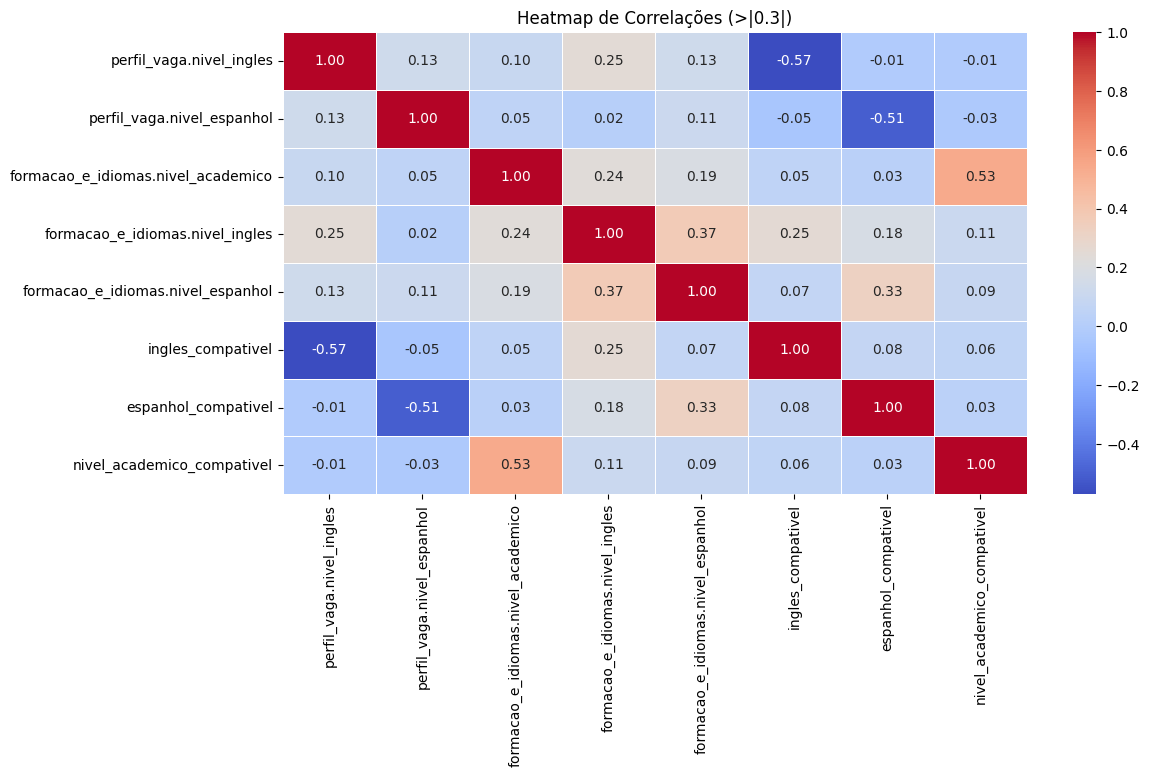

In [57]:
# 1. Calcula a matriz de correlação (numeric_only ignora objetos)
corr = df_merge_ordinal.corr(numeric_only=True)

# 2. Define o limiar mínimo de correlação
limiar = 0.3

# 3. Cria uma máscara booleana onde as correlações absolutas são maiores que o limiar (sem a diagonal)
mascara = (corr.abs() > limiar) & (corr.abs() < 1.0)

# 4. Seleciona as colunas que têm pelo menos uma correlação forte
colunas_correlacionadas = mascara.any()[mascara.any()].index

# 5. Submatriz com apenas colunas correlacionadas
sub_corr = corr.loc[colunas_correlacionadas, colunas_correlacionadas]

# 6. Plota o heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sub_corr, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title(f'Heatmap de Correlações (>|{limiar}|)')
plt.show()

In [58]:
# colunas escolhidas segundo a matriz de calor do passo anterior
colunas_heatmap = ['nivel_academico_compativel',
                   'formacao_e_idiomas.nivel_academico',
                   'formacao_e_idiomas.nivel_ingles',
                   'formacao_e_idiomas.nivel_espanhol',
                   'espanhol_compativel',
                   'ingles_compativel']

## Treinando

### Preparando

In [59]:
def calcular_distancia(row, coluna_candidato, coluna_vaga):
    """
    Função genérica que compara o nível de proficiência em qualquer idioma.

    Argumentos"""
    # Usa os argumentos para pegar os valores das colunas corretas
    return row[coluna_candidato] - row[coluna_vaga]

df_merge_ordinal['distancia_ingles'] = df_merge_ordinal.apply(calcular_distancia,
                                                              axis=1,
                                                              args=('formacao_e_idiomas.nivel_ingles', 'perfil_vaga.nivel_ingles'))
df_merge_ordinal['distancia_espanhol'] = df_merge_ordinal.apply(calcular_distancia,
                                                              axis=1,
                                                              args=('formacao_e_idiomas.nivel_espanhol', 'perfil_vaga.nivel_espanhol'))
df_merge_ordinal['distancia_nivel_academico'] = df_merge_ordinal.apply(calcular_distancia,
                                                              axis=1,
                                                              args=('formacao_e_idiomas.nivel_academico', 'perfil_vaga.nivel_academico'))


In [60]:
df_merge_ordinal['vaga_aceita_CLT'] = df_merge_ordinal['informacoes_basicas.tipo_contratacao'].str.contains('CLT', case=False, na=False).astype(int)
df_merge_ordinal['vaga_aceita_PJ'] = df_merge_ordinal['informacoes_basicas.tipo_contratacao'].str.contains('PJ', case=False, na=False).astype(int)
df_merge_ordinal['vaga_aceita_Cooperado'] = df_merge_ordinal['informacoes_basicas.tipo_contratacao'].str.contains('Cooperado', case=False, na=False).astype(int)
df_merge_ordinal['vaga_aceita_Estagio'] = df_merge_ordinal['informacoes_basicas.tipo_contratacao'].str.contains('Estagiário', case=False, na=False).astype(int)
df_merge_ordinal['vaga_eh_Hunting'] = df_merge_ordinal['informacoes_basicas.tipo_contratacao'].str.contains('Hunting', case=False, na=False).astype(int)

# Depois de criar as novas colunas, você pode remover as colunas de trabalho
df_merge_ordinal = df_merge_ordinal.drop(columns=['informacoes_basicas.tipo_contratacao'])

In [61]:
#colunas_compatibilidade = ['area_compativel', 'ingles_compativel', 'espanhol_compativel', 'estado_compativel', 'nivel_academico_compativel']
colunas_compatibilidade = ['area_compativel', 'estado_compativel', 'distancia_ingles', 'distancia_espanhol', 'distancia_nivel_academico']
teste = ['formacao_e_idiomas.nivel_academico', 'perfil_vaga.nivel_academico']
colunas_tipo_vaga = ['vaga_aceita_CLT', 'vaga_aceita_PJ', 'vaga_aceita_Cooperado', 'vaga_aceita_Estagio', 'vaga_eh_Hunting']
colunas_para_treino_2 = colunas_compatibilidade + ['perfil_vaga.nivel profissional'] + teste + colunas_tipo_vaga
#colunas_para_treino_2 = colunas_compatibilidade + colunas_categoricas

df_resultados = pd.DataFrame(columns=['modelo', 'acuracia', 'f1_score'])

In [62]:
df_merge_ordinal[colunas_categoricas].head()

,perfil_vaga.nivel profissional,perfil_vaga.nivel_academico,perfil_vaga.nivel_ingles,perfil_vaga.nivel_espanhol,formacao_e_idiomas.nivel_academico,formacao_e_idiomas.nivel_ingles,formacao_e_idiomas.nivel_espanhol
0,5,11,0,0,11,3,1
1,6,5,0,0,11,4,3
2,6,5,2,0,11,5,0
3,6,5,2,0,11,1,0
4,4,11,1,1,11,3,1


In [63]:
df_merge_ordinal[colunas_para_treino_2].head()

,area_compativel,estado_compativel,distancia_ingles,distancia_espanhol,distancia_nivel_academico,perfil_vaga.nivel profissional,formacao_e_idiomas.nivel_academico,perfil_vaga.nivel_academico,vaga_aceita_CLT,vaga_aceita_PJ,vaga_aceita_Cooperado,vaga_aceita_Estagio,vaga_eh_Hunting
0,0,1,3,1,0,5,11,11,0,1,0,0,0
1,0,1,4,3,6,6,11,5,0,1,0,0,0
2,0,0,3,0,6,6,11,5,0,1,0,0,0
3,0,0,-1,0,6,6,11,5,0,1,0,0,0
4,1,0,2,0,0,4,11,11,1,1,0,0,0


### Modelos

In [64]:
# RANDOM FOREST
df_resultados = treinar_random_forest(df_merge_ordinal, colunas_heatmap, 'aprovado', '- heatmap', df_resultados)
df_resultados = treinar_random_forest(df_merge_ordinal, colunas_categoricas, 'aprovado', '- análise', df_resultados)
df_resultados = treinar_random_forest(df_merge_ordinal, colunas_para_treino_2, 'aprovado', '- compatibilidade', df_resultados)

# XGBOOST
df_resultados = treinar_xgboost(df_merge_ordinal, colunas_heatmap, 'aprovado', '- heatmap', df_resultados)
df_resultados = treinar_xgboost(df_merge_ordinal, colunas_categoricas, 'aprovado', '- análise', df_resultados)
df_resultados = treinar_xgboost(df_merge_ordinal, colunas_para_treino_2, 'aprovado', '- compatibilidade', df_resultados)

# LOGISTIC REGRESSION
df_resultados = treinar_log_regression(df_merge_ordinal, colunas_heatmap, 'aprovado', '- heatmap', df_resultados)
df_resultados = treinar_log_regression(df_merge_ordinal, colunas_categoricas, 'aprovado', '- análise', df_resultados)
df_resultados = treinar_log_regression(df_merge_ordinal, colunas_para_treino_2, 'aprovado', '- compatibilidade', df_resultados)

# KNN
df_resultados = treinar_knn(df_merge_ordinal, colunas_heatmap, 'aprovado', '- heatmap', df_resultados)
df_resultados = treinar_knn(df_merge_ordinal, colunas_categoricas, 'aprovado', '- análise', df_resultados)
df_resultados = treinar_knn(df_merge_ordinal, colunas_para_treino_2, 'aprovado', '- compatibilidade', df_resultados)

# COMPARATIVO
print('\n\ncompilado:\n', df_resultados.sort_values(by='acuracia', ascending=False))




compilado:
                                   modelo  acuracia  f1_score
5              XGBOOST - compatibilidade  0.568011  0.579228
11                 KNN - compatibilidade  0.559809  0.548387
2         RandomForest - compatibilidade  0.557758  0.564896
4                      XGBOOST - análise  0.555707  0.553571
10                         KNN - análise  0.551606  0.536723
3                      XGBOOST - heatmap  0.550923  0.585489
8   LogisticRegression - compatibilidade  0.550923  0.506386
1                 RandomForest - análise  0.549556  0.571800
6           LogisticRegression - heatmap  0.548189  0.623362
7           LogisticRegression - análise  0.546822  0.572534
0                 RandomForest - heatmap  0.545455  0.573991
9                          KNN - heatmap  0.524265  0.467075


# novos testes

## GridSearchCV

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In [66]:
# Dicionário com os parâmetros e os valores a serem testados
param_grid = {
    'n_estimators': [100, 200, 300],          # Número de "árvores" no modelo
    'max_depth': [3, 4, 5],                   # Profundidade máxima de cada árvore
    'learning_rate': [0.01, 0.1, 0.2],        # Taxa de aprendizado
    'subsample': [0.8, 1.0]                   # Fração de amostras usadas para treinar cada árvore
}
# Total de combinações a serem testadas: 3 * 3 * 3 * 2 = 54 combinações

In [67]:
# Crie uma instância do modelo
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Crie a instância do GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [68]:
X_train, X_test, y_train, y_test = separar_treino_teste(df_merge_ordinal, colunas_para_treino_2, 'aprovado')

In [69]:
# Executa a busca em grade. Isso vai testar as 54 combinações, 5 vezes cada (270 treinos)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


g:\Fontes\fiap-challenge-5\fiap5\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [70]:
# 1. Ver os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

# 2. Ver a melhor performance (acurácia) durante a validação cruzada
print("Melhor acurácia no cross-validation: ", grid_search.best_score_)

# 3. Usar o melhor modelo encontrado para fazer previsões
# O 'best_estimator_' é um modelo XGBoost já treinado com os melhores parâmetros
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Agora você pode calcular a acurácia final no conjunto de teste
from sklearn.metrics import accuracy_score
print("Acurácia no conjunto de teste: ", accuracy_score(y_test, predictions))

Melhores parâmetros encontrados:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Melhor acurácia no cross-validation:  0.5810256410256411
Acurácia no conjunto de teste:  0.5782638414217361
